In [1]:
import json
import time
import os

from pymongo import MongoClient

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import line_profiler

from imputation import *
from solve_cubic import *

%load_ext line_profiler
%load_ext Cython
%matplotlib inline

client = MongoClient("localhost", 27017)
db = client['usgs']

In [2]:
to_shift = {
    14137000 : -687,
    7377500  : +2,
    8186500  : +2,
    11456000 : +2
}


def align_measurements(t_meas, y_meas, t_corr, y_corr):
    dt_corr, n_corr = np.unique(t_corr[1:] - t_corr[:-1], return_counts=True)
    dt_meas, n_meas = np.unique(t_meas[1:] - t_meas[:-1], return_counts=True)
    dt = min(dt_corr[np.argmax(n_corr)], dt_meas[np.argmax(n_meas)])
    
    offset_corr = max(t_corr[0] - t_meas[0], 0)
    offset_meas = max(t_meas[0] - t_corr[0], 0)
    N = (max(t_corr[-1], t_meas[-1]) - min(t_corr[0], t_meas[0])) // dt + 1
    
    y_corr_new = np.zeros(N) - 1
    y_meas_new = np.zeros(N) - 1
    
    idx_corr = np.cumsum((t_corr[1:] - t_corr[:-1]) // dt) + offset_corr // dt
    idx_meas = np.cumsum((t_meas[1:] - t_meas[:-1]) // dt) + offset_meas // dt
    
    y_corr_new[idx_corr] = y_corr[1:]
    y_meas_new[idx_meas] = y_meas[1:]
    
    y_corr_new[0] = y_corr[0]
    y_meas_new[0] = y_meas[0]
    
    return y_meas_new, y_corr_new


def get_data(db, site_id):
    data_m = db['measured'].find_one({'site_no': site_id})
    data_c = db['corrected'].find_one({'site_no': site_id})
    
    if data_m is None or data_c is None:
        raise Exception("Site not found")
        
    Tm = np.array(data_m['utc'], dtype=np.int32)
    Zm = np.array(data_m['gh'],  dtype=np.float32)
    
    Tc = np.array(data_c['utc'], dtype=np.int32)
    Zc = np.array(data_c['gh'],  dtype=np.float32)
    
    if site_id in to_shift:
        Zm += to_shift[site_id]
        Zc += to_shift[site_id]
    
    return Tm, Zm, Tc, Zc


def mark_anomaly(y_m, y_c, anomaly_thresh):
    return np.logical_or(y_c < 0, np.abs(y_c - y_m) > anomaly_thresh)  

In [4]:
sites = db['cites']
measured = db['measured']
corrected = db['corrected']

cursor = sites.find()
sid = [c['site_no'] for c in cursor]

7332500


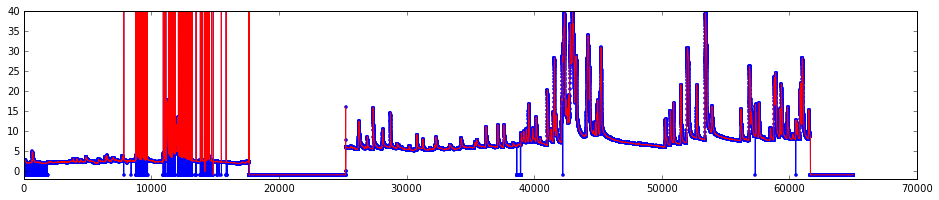

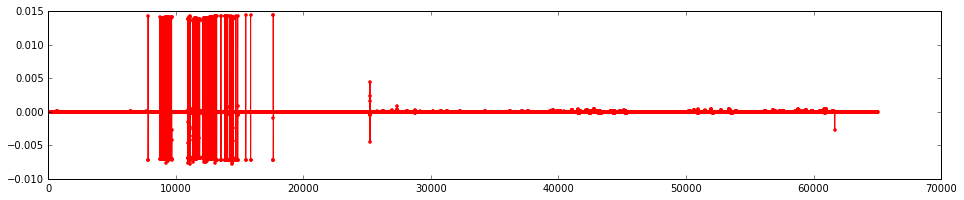

In [5]:
si = 7332500 # sorted(impurity)[-67]

Tm, Zm, Tc, Zc = get_data(db, si)

abs_thresh = np.median(Zm) + 15*np.subtract(*np.percentile(Zm, [90, 10]))
Zm[Zm <= 0] = -1
Zm[Zm > abs_thresh] = -1

Ym, Yc = align_measurements(Tm, Zm, Tc, Zc)  
Qm = fill_gaps(Ym, max_gap = 2000, spike_size = 2, window_size = 4*12)
dZ = (Qm[1:] - Qm[:-1]) / (Tm[1] - Tm[0])
ddZ = (dZ[1:] - dZ[:-1]) / (Tm[1] - Tm[0])

plt.figure(figsize = (16,3))
plt.plot(Ym, 'b.-')
plt.plot(Qm, 'r-')
plt.ylim(-2,40)
#plt.xlim(8700, 9000)

plt.figure(figsize = (16,3))
plt.plot(dZ, 'r.-')
#plt.plot(ddZ, 'b.-')
#plt.xlim(8700, 9000)

print(si)